# Analysis of Anime Global Distribution

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Directory and file management
import os
from pathlib import Path
import json
import pickle

# Image processing
import glob
import cv2

# Language detection
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from langdetect import DetectorFactory
DetectorFactory.seed = 0

# Plotting
import matplotlib.pyplot as plt

# Set font as Arial
plt.rcParams['font.family'] = 'Arial'

In [2]:
# Define directories
project_dir = Path(os.getcwd())
data_dir = project_dir / 'data' / 'final_project'
results_dir = project_dir / 'results' / 'final_project'

In [3]:
# Construct the full path to the database file
offline_db_path = data_dir / 'anime-offline-database' / 'anime-offline-database.json'

# Open and load the entire JSON file into a Python dictionary
try:
    with open(offline_db_path, 'r', encoding='utf-8') as f:
        full_database_content = json.load(f)

    # Access the list of anime entries using the 'data' key
    anime_list_data = full_database_content.get('data', []) # Use .get() for safety

    # Create the pandas DataFrame from this list of dictionaries
    db_df = pd.DataFrame(anime_list_data)

    print("Successfully loaded the data into a pandas DataFrame.")
    print("DataFrame shape:", db_df.shape)
    print("DataFrame columns:", db_df.columns.tolist())

except FileNotFoundError:
    print(f"Error: File not found at {offline_db_path}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {offline_db_path}. Check file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Show number of animes by type
db_df[['type']].value_counts()

Successfully loaded the data into a pandas DataFrame.
DataFrame shape: (35795, 13)
DataFrame columns: ['sources', 'title', 'type', 'episodes', 'status', 'animeSeason', 'picture', 'thumbnail', 'duration', 'score', 'synonyms', 'relatedAnime', 'tags']


type   
SPECIAL    10157
TV          9055
MOVIE       6177
ONA         5800
OVA         4509
UNKNOWN       97
Name: count, dtype: int64

In [4]:
NUM_TRANSLATIONS = 0
ERROR_TITLES = []

def detect_languages_for_titles(titles_list):
    """
    Detects the language for each string in a list of titles.

    Args:
        titles_list (list): A list of strings (titles).

    Returns:
        list: A list of language codes corresponding to each synonym,
              or 'unknown' if detection fails for a synonym.
    """
    global NUM_TRANSLATIONS
    global ERROR_TITLES

    languages = []
    if isinstance(titles_list, list):
        for title in titles_list:
            try:
                # Langdetect might raise an exception for very short strings
                lang = detect(title)
                languages.append(lang)
            except LangDetectException:
                # Handle cases where language detection fails (e.g., empty string, non-text)
                # languages.append('unknown')
                ERROR_TITLES.append(title)
            except Exception as e:
                # Catch any other potential errors during detection
                #  print(f"Error detecting language for '{title}': {e}")
                #  languages.append('error')
                ERROR_TITLES.append(title)
    else:
        # Handle cases where the column value is not a list
        print(f"Warning: Expected list, got {type(titles_list)}")

    # Add number of translations to global variable
    NUM_TRANSLATIONS += len(languages)
    
    return languages

In [5]:
# Create new column called titles, which is titles appended to synonyms
db_df['titles'] = db_df.apply(lambda row: [row['title']] + row['synonyms'], axis=1)

# Processed data directory
processed_data_dir = data_dir / 'processed'
title_lang_path = processed_data_dir / 'title_languages.pkl'
title_lang_path.parent.mkdir(parents=True, exist_ok=True)

# Apply the function to the 'synonyms' column to create a new column
if title_lang_path.exists():
    print(f"Loading previously computed languages...")
    try:
        with open(title_lang_path, 'rb') as f:
            # Load the pickled Series
            db_df['title_languages'] = pickle.load(f)
        print("Successfully loaded pickled data.")
    except Exception as e:
        print(f"Error loading pickled data: {e}. Recomputing languages.")
        # If loading fails, fall through to the computation step
        # Remove the potentially incomplete column
        if 'title_languages' in db_df.columns:
             db_df = db_df.drop(columns=['title_languages'])

else:
    print(f"Pickled data not found. Computing languages...")
    # Register tqdm with pandas
    tqdm.pandas()

    # Apply the function using progress_apply
    db_df['title_languages'] = db_df['titles'].progress_apply(detect_languages_for_titles)

    # After computation, pickle the result
    try:
        with open(title_lang_path, 'wb') as f:
            # Pickle the Series containing the language lists
            pickle.dump(db_df['title_languages'], f)
        print(f"Successfully computed and saved title languages.")
    except Exception as e:
        print(f"Error saving pickled data: {e}")

Loading previously computed languages...
Successfully loaded pickled data.


In [6]:
NUM_TRANSLATIONS

0

In [7]:
# Print total number of language detections
print(f"Total number of language detections: {NUM_TRANSLATIONS}")

# Compute unique synonym languages for each anime
db_df['unique_languages'] = db_df['title_languages'].apply(lambda x: list(set(x)))

# If unknown or error is in the list, delete that value from the list
db_df['unique_languages'] = db_df['unique_languages'].apply(lambda x: [lang for lang in x if lang not in ['unknown', 'error']])

# Compute number of unique languages for each anime
db_df['num_languages'] = db_df['unique_languages'].apply(lambda x: len(x))

# If num languages is 0, make it 1
# db_df['num_languages'] = db_df['num_languages'].apply(lambda x: 1 if x == 0 else x)

# Add year column, which is animeSeason['year]
db_df['year'] = db_df['animeSeason'].apply(lambda x: x['year'])

# Drop rows where year is NA
print("Number of animes:", len(db_df))
db_df = db_df[db_df['year'].notna()].copy()
print("Number of animes with valid year:", len(db_df))

# Convert year to int
db_df['year'] = db_df['year'].astype(int)

# Add season column, which is animeSeason['season']
db_df['season'] = db_df['animeSeason'].apply(lambda x: x['season'])

# Replace types
type_map = {
    'UNKNOWN': 'Other',
    'TV': 'TV series',
    'MOVIE': 'Movie',
    'SPECIAL': 'Special',
    'OVA': 'OVA',
    'ONA': 'ONA'
}

# Replace types
db_df['type'] = db_df['type'].map(type_map)

# Print number of animes by type
print(db_df['type'].value_counts())

Total number of language detections: 0
Number of animes: 35795
Number of animes with valid year: 34598
type
Special      10043
TV series     8514
Movie         6052
ONA           5465
OVA           4452
Other           72
Name: count, dtype: int64


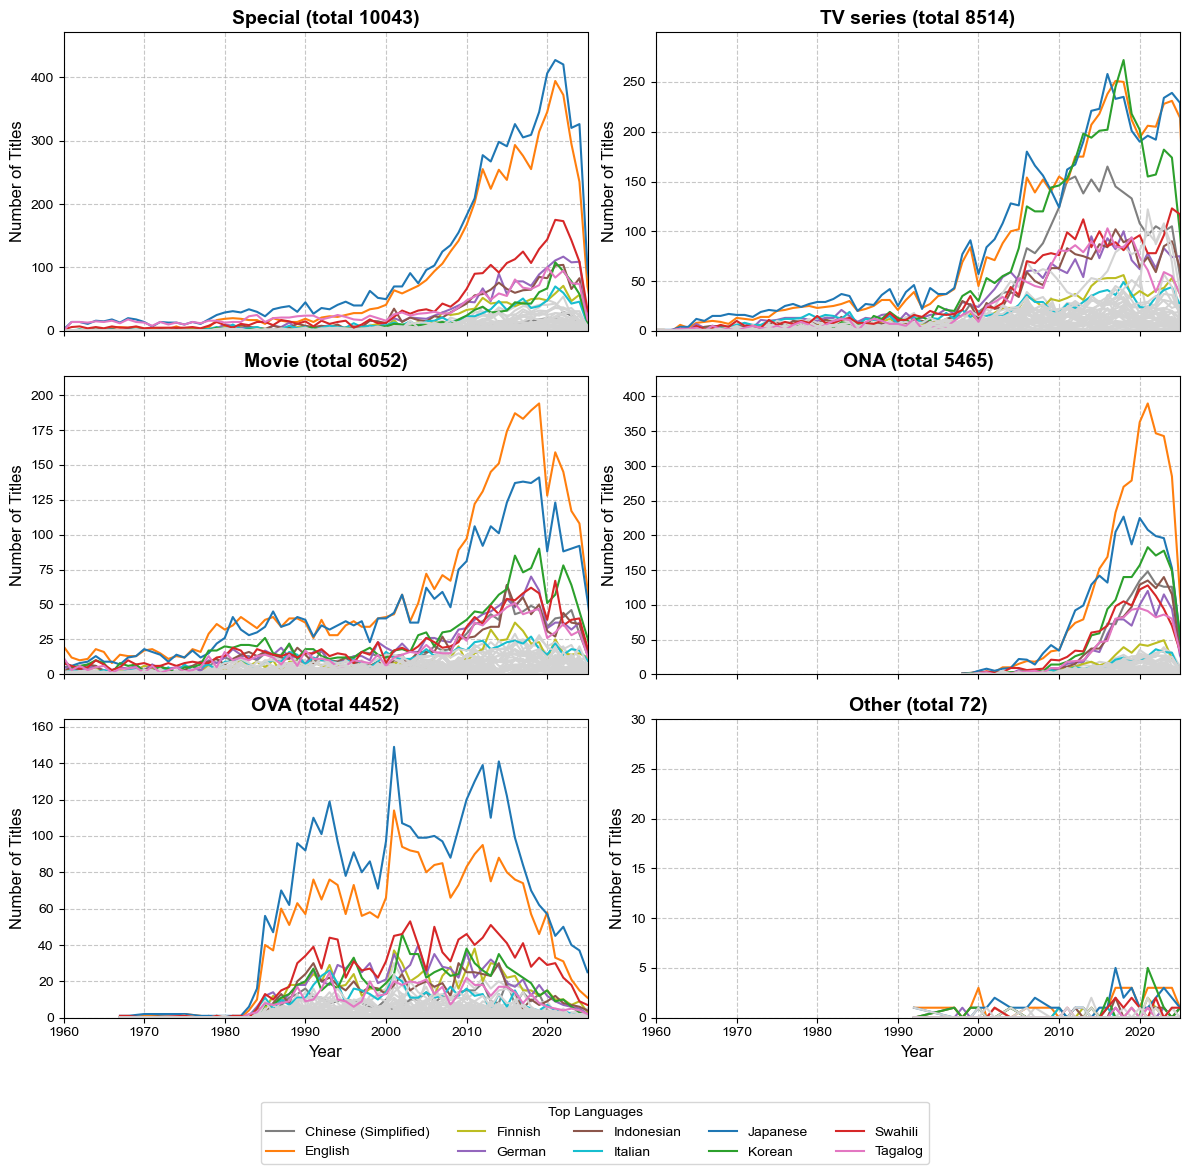

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Explode languages so one row per anime-language
plot_df = db_df.explode('unique_languages')

# Drop rows with missing or UNKNOWN type
plot_df = plot_df[plot_df['type'].notna()]
# plot_df = plot_df[plot_df['type'] != 'Other']

# Load mapping file
lang_map_df = pd.read_csv("data/language_codes.csv")
LANG_CODE_TO_NAME = dict(zip(lang_map_df['code'], lang_map_df['name']))
plot_df['language_name'] = plot_df['unique_languages'].map(LANG_CODE_TO_NAME).fillna(plot_df['unique_languages'])

# Group by type, year, and language
grouped = (
    plot_df
    .groupby(['type', 'year', 'language_name'])
    .size()
    .reset_index(name='count')
)

# Top 10 languages overall
top_langs = (
    grouped.groupby('language_name')['count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

# Assign color palette
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
top_lang_colors = dict(zip(top_langs, color_cycle[:len(top_langs)]))
default_color = 'lightgray'

# Get metadata
types = grouped['type'].unique()
languages = sorted(grouped['language_name'].unique())
num_by_type = db_df['type'].value_counts()

# Sort types by number of animes
types = sorted(types, key=lambda x: num_by_type[x], reverse=True)

# Compute consistent axis limits
# year_min, year_max = grouped['year'].min(), grouped['year'].max()
year_min = 1960
year_max = 2025
y_max = grouped['count'].max()

# Subplot layout: 3x2
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharex=True, sharey=False)
axes = axes.flatten()

# Track legend handles
line_handles = []
line_labels = []

# Plot each type
for i, t in enumerate(types):
    ax = axes[i]
    subset = grouped[grouped['type'] == t]
    pivot_df = subset.pivot(index='year', columns='language_name', values='count').fillna(0)

    for lang in pivot_df.columns:
        x = pivot_df.index.to_numpy()
        y = pivot_df[lang].to_numpy()
        color = top_lang_colors.get(lang, default_color)
        line, = ax.plot(x, y, label=lang, color=color)

        if lang in top_langs and lang not in line_labels:
            line_handles.append(line)
            line_labels.append(lang)

    ax.set_xlim(year_min, year_max)
    # ax.set_ylim(0, y_max * 1.05)
    # Get current ylim
    current_ylim = ax.get_ylim()
    ax.set_ylim(0, current_ylim[1] * 1.05)

    # If UNKNOWN (Other), set ymax = 100
    if t == 'Other':
        ax.set_ylim(0, 30)

    ax.set_title(f"{t} (total {num_by_type[t]})", fontsize=14, fontweight='bold')
    ax.set_ylabel("Number of Titles", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

# Remove unused axes if any
for j in range(len(types), len(axes)):
    fig.delaxes(axes[j])

# Set xlabel only for bottom row of active subplots
for ax in axes[-ncols:]:
    if ax in axes[:len(types)]:
        ax.set_xlabel("Year", fontsize=12)

# Add Other to the legend
# line_handles.append(plt.scatter([], [], color='lightgray', label='Other'))
# line_labels.append('Other')

# Shared legend at bottom
fig.legend(
    line_handles,
    line_labels,
    title="Top Languages",
    # loc="lower left",
    # bbox_to_anchor=(0.525, 0.255),
    # ncol=min(len(top_langs), 3),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=min(len(top_langs), 5),
    fontsize=10
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Save plot
plt.savefig(results_dir / "anime_language_distribution.png", dpi=600, bbox_inches='tight')
plt.savefig(results_dir / "anime_language_distribution.pdf", bbox_inches='tight')
plt.show()

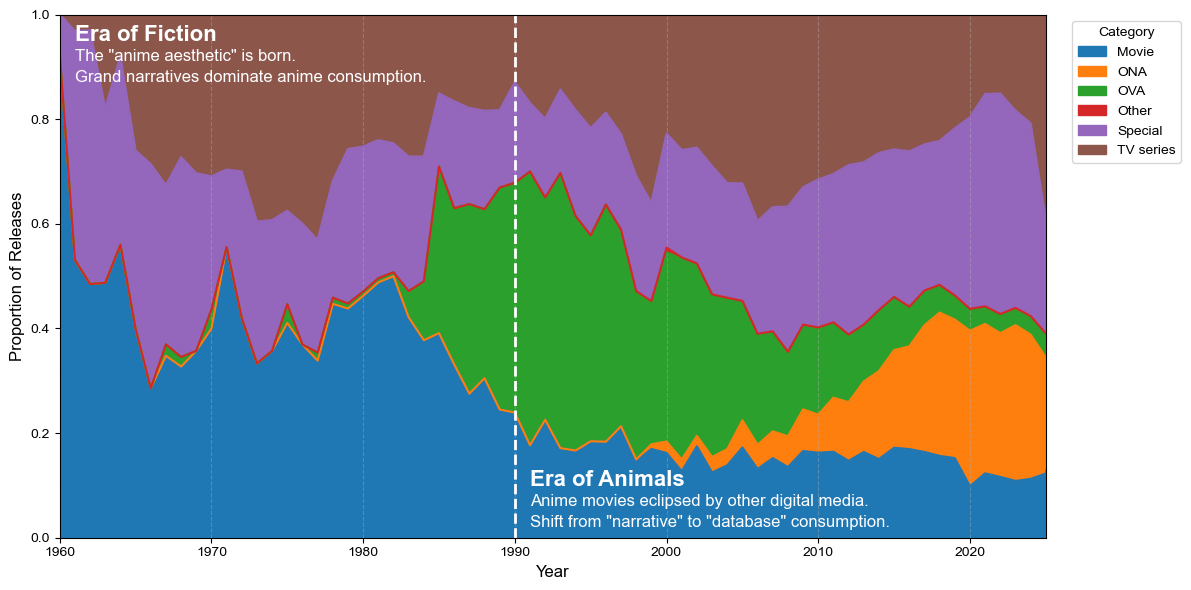

In [14]:
year_type_counts = (
    db_df.groupby(["year", "type"])
         .size()
         .reset_index(name="count")
)

counts_wide = (
    year_type_counts
    .pivot(index="year", columns="type", values="count")
    .fillna(0)
    .sort_index()
)

proportions = counts_wide.div(counts_wide.sum(axis=1), axis=0)
# proportions = proportions[types]

fig, ax = plt.subplots(figsize=(12, 6))
proportions.plot(kind="area", stacked=True, ax=ax)

# Set limits to 1960 to 2025
ax.set_xlim(1960, 2025)
ax.set_ylim(0, 1)
# ax.set_title("Proportion of Anime Media Types Across Time")
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Proportion of Releases", fontsize=12)
ax.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=10)

# Draw red vertical line at 1990, labeled Database Era
ax.axvline(x=1990, color='white', linestyle='--', linewidth=2)
ax.text(1961, 0.96, 'Era of Fiction', color='white', fontsize=16, ha='left', va='center', fontweight='bold')
ax.text(1961, 0.92, 'The "anime aesthetic" is born.', color='white', fontsize=12, ha='left', va='center')
ax.text(1961, 0.88, 'Grand narratives dominate anime consumption.', color='white', fontsize=12, ha='left', va='center')
ax.text(1991, 0.11, 'Era of Animals', color='white', fontsize=16, ha='left', va='center', fontweight='bold')
ax.text(1991, 0.07, 'Anime movies eclipsed by other digital media.', color='white', fontsize=12, ha='left', va='center')
ax.text(1991, 0.03, 'Shift from "narrative" to "database" consumption.', color='white', fontsize=12, ha='left', va='center')

# Add y-axis grid
ax.grid(True, linestyle='--', alpha=0.4, axis='x')
plt.tight_layout()

# Save plot
plt.savefig(results_dir / "anime_type_distribution.png", dpi=600, bbox_inches='tight')
plt.savefig(results_dir / "anime_type_distribution.pdf", bbox_inches='tight')
plt.show()

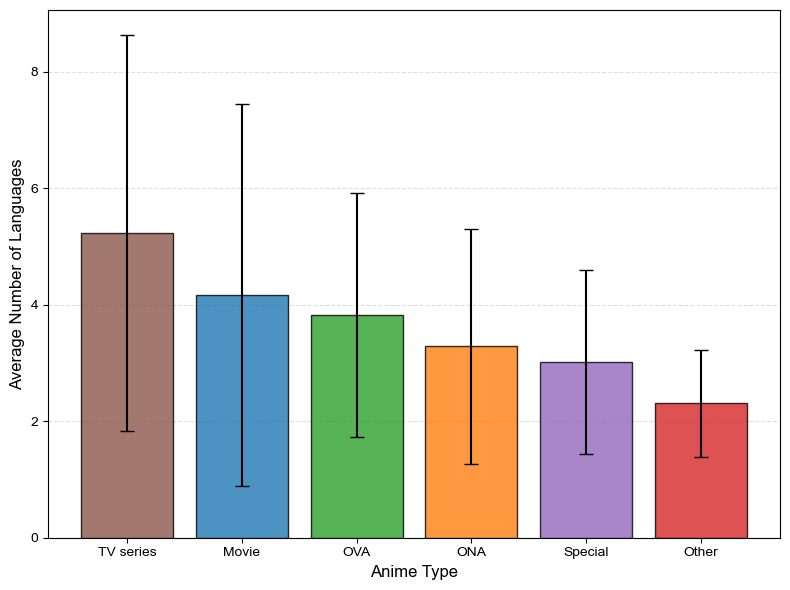

In [ ]:
# Group across all years, compute overall mean and std by type
type_lang_stats = (
    db_df.groupby("type")["num_languages"]
         .agg(["mean", "std"])
         .reset_index()
         .rename(columns={"mean": "avg_languages", "std": "std_languages"})
         .sort_values("avg_languages", ascending=False)
)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(
    type_lang_stats["type"],
    type_lang_stats["avg_languages"],
    yerr=type_lang_stats["std_languages"],
    capsize=5, edgecolor='black',
    # brown, blue, green, orange, purple, red
    color = ['#8c564b', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#d62728'],
    alpha=0.8, zorder=3
)

ax.set_ylabel("Average Number of Languages", fontsize=12)
ax.set_xlabel("Anime Type", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4, axis='y')
plt.tight_layout()

# Save plot
plt.savefig(results_dir / "anime_type_mean_languages.png", dpi=600, bbox_inches='tight')
plt.savefig(results_dir / "anime_type_mean_languages.pdf", bbox_inches='tight')
plt.show()

# TITLE IS: Av

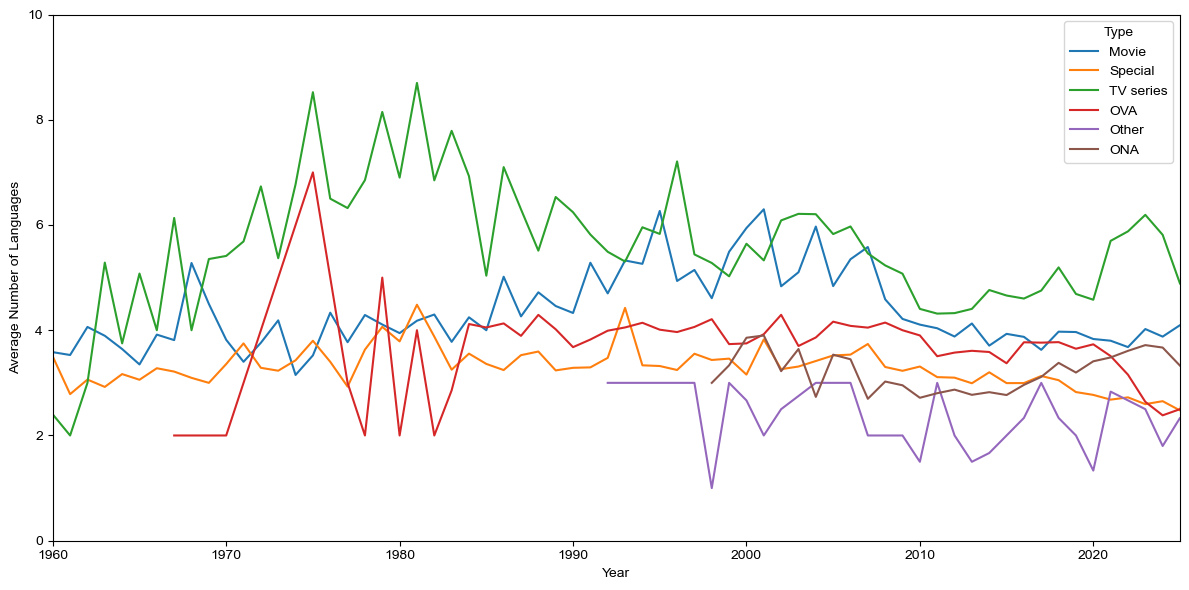

In [116]:
lang_stats = (
    db_df.groupby(["year", "type"])["num_languages"]
         .agg(["mean", "std"])
         .reset_index()
         .rename(columns={"mean": "avg_languages", "std": "std_languages"})
)

fig, ax = plt.subplots(figsize=(12, 6))

for anime_type in lang_stats['type'].unique():
    subset = lang_stats[lang_stats['type'] == anime_type].sort_values("year")
    
    years = subset['year'].to_numpy()
    avg = subset['avg_languages'].to_numpy()
    std = subset['std_languages'].to_numpy()
    
    ax.plot(years, avg, label=anime_type)
    # ax.fill_between(years, avg - std, avg + std, alpha=0.2)

# Set limits to 1960 to 2025
ax.set_xlim(1960, 2025)

# Set ylim to 0 to 10
ax.set_ylim(0, 10)

# ax.set_title("Average Number of Languages per Anime Over Time by Type")
ax.set_xlabel("Year")
ax.set_ylabel("Average Number of Languages")
ax.legend(title="Type")
plt.tight_layout()
plt.show()

In [92]:
plot_df[plot_df['title'].str.contains('Gundam')]['language_name'].value_counts()

language_name
Japanese                161
English                 125
German                   97
Indonesian               64
Swahili                  62
Portuguese               48
Chinese (Simplified)     41
Korean                   37
Romanian                 27
Thai                     21
Russian                  17
French                   16
Afrikaans                16
Italian                  14
Norwegian                11
Estonian                  9
Bulgarian                 8
Vietnamese                8
Swedish                   8
Tagalog                   7
Arabic                    7
Finnish                   6
Catalan                   6
Hebrew                    5
Spanish                   4
Danish                    4
Albanian                  3
Dutch                     3
Persian                   3
Slovenian                 3
Ukrainian                 2
Turkish                   2
Welsh                     2
Somali                    2
Czech                     2
Polish